In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

import sys
sys.path.append("..")

plt.style.use("~/.config/matplotlib/notebook")

## Modis granule

In [2]:
from cloud_colocations.formats import ModisMyd03, ModisMyd021km

modis_granule     = ModisMyd021km("../cache/MYD021KM.A2009002.0715.006.2012058150852.hdf")
modis_geo_granule = ModisMyd03("../cache/MYD03.A2009002.0715.006.2012054204904.hdf")

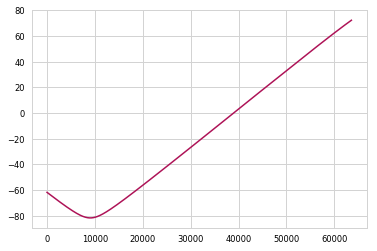

In [13]:
lats
lats = caliop_data.file_handle.select("Latitude")[:]
plt.plot(lats)

In [26]:
from cloud_colocations.formats import Hdf4File
caliop_data = Hdf4File("../cache/CAL_LID_L1-Standard-V4-10.2009-01-02T06-34-02ZD.hdf")
lats = caliop_data.file_handle.select("Latitude")[:]
i = np.where(lats > 42.0)[0][0]
j = np.where(lats > 46.0)[0][0]
lats = lats[i : j]
lons = caliop_data.file_handle.select("Longitude")[:][i : j]
bs   = caliop_data.file_handle.select("Total_Attenuated_Backscatter_532")[:][i : j]
p    = caliop_data.file_handle.select("Pressure")[:][i : j, :]

In [27]:
z = - np.log(p / 1e3) * 8.0
z[np.isnan(z)] = 0.0
x_p = np.arange(p.shape[1])
x_l = np.arange(bs.shape[1])
z_l = np.interp(x_l / x_l[-1] * x_p[-1], x_p, z[0, :])

/home/simon/build/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [31]:
from scipy.signal import convolve
x = np.arange(11)
xx, _ = np.meshgrid(x, x)
k = np.exp(- (xx - 5) ** 2)
k /= k.sum()
bs_c = convolve(np.maximum(bs, 0.0), k, "same")

In [32]:
lon_lims = [85, 95]
lat_lims = [40, 50]

In [46]:
lons[0, -1]

89.99251

/home/simon/src/matplotlib/lib/matplotlib/figure.py:2052: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


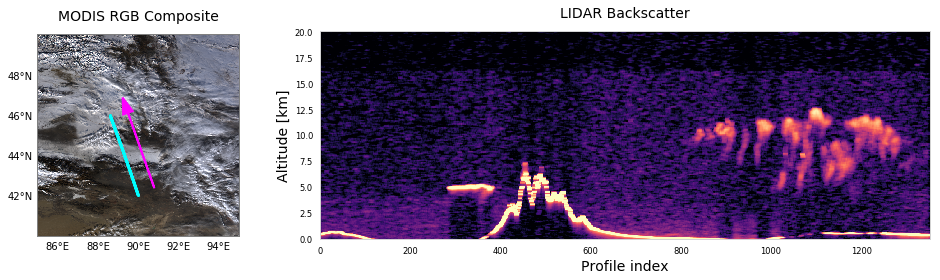

In [75]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
import matplotlib.ticker as ticker
from cloud_colocations.plots   import plot_modis_granule_composite, plot_scalar_field

f = plt.figure(figsize = (16, 8))

gs = GridSpec(1, 2, width_ratios = [0.33, 1.0], wspace = 0.2)
ax, _, gl = plot_modis_granule_composite(modis_granule, modis_geo_granule, grid_spec = gs[0], gain = 0.5)
ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)
ax.set_title("MODIS RGB Composite", fontsize = 14)

gl.xlocator = ticker.MaxNLocator(5)
gl.ylocator = ticker.MaxNLocator(5)

ax.scatter(lons, lats, color = "aqua", s = 4)

x  = lons[0, 0] + 0.8
y  = lats[0, 0] + 0.4
dx = lons[-100, 0] - lons[0, 0]
dy = lats[-100, 0] - lats[0, 0]
arr = ax.arrow(x, y, dx, dy, head_width=0.5, head_length=0.8, fc='magenta', ec='magenta', lw = 2)

#x = np.broadcast_to(lats, z.shape)
ax = plt.subplot(gs[0, 1])
x = np.arange(bs_c.shape[0])
y = z_l
ax.pcolormesh(x, y, np.maximum(bs_c, 0.0).T, norm = LogNorm(vmin = 1e-3, vmax = 1e-1))
ax.set_title("LIDAR Backscatter", fontsize = 14)
ax.set_ylabel("Altitude [km]", fontsize = 14)
ax.set_xlabel("Profile index", fontsize = 14)
ax.set_ylim([0, 20])
ax.set_aspect(23)

plt.tight_layout()
f.savefig("../plots/modis_caliop.png", bbox_inches = "tight")

In [62]:
arr.xy

array([[88.65310296, 46.19323822],
       [88.70987171, 46.10720155],
       [88.68676012, 46.09907111],
       [90.0929796 , 42.10175284],
       [90.09203627, 42.10142099],
       [88.68581679, 46.09873925],
       [88.66270519, 46.09060881],
       [88.65310296, 46.19323822]])

In [77]:
lats

array([[49.99797 ],
       [49.99505 ],
       [49.992123],
       ...,
       [40.006195],
       [40.00322 ],
       [40.000244]], dtype=float32)

In [38]:
classes = caliop_data.get_feature_class_curtain()



In [39]:
classes.shape

(21120, 10)

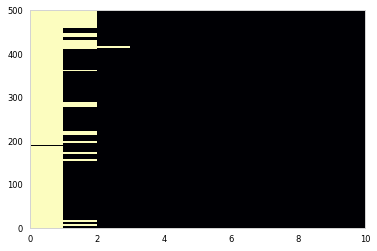

In [44]:
plt.pcolor(classes[:500, :])

NameError: name 'lon_lims' is not defined

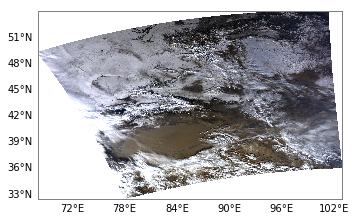

In [49]:
from cloud_colocations.plots   import plot_modis_granule_composite, plot_scalar_field
from matplotlib.gridspec import GridSpec
f = plt.figure(figsize = (12, 6))
gs = GridSpec(1, 2)

ax, _, _ = plot_modis_granule_composite(modis_granule, modis_geo_granule, grid_spec = gs[0], gain = 0.5)
ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)
ax.set_title("MODIS RGB composite", fontsize = 14)

lats = modis_geo_granule.lats
lons = modis_geo_granule.lons
x    = modis_granule.data[30, :, :]
ax, _, gl = plot_scalar_field(x, lats, lons, grid_spec = gs[1])
ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)
ax.set_title("MODIS $12 \mu m$ IR channel", fontsize = 14)
ax.set_yticks([])

gl.ylabels_left = False

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.tight_layout()
f.savefig("../plots/modis_obs.png", bbox_inches = "tight")


## Modis input data

In [81]:
from cloud_colocations.products import set_cache
set_cache("../cache")

In [82]:
from cloud_colocations.raw_data import RawData
data = RawData(2009, 2, 20, basepath = "..")

Loading files from  ../2009/002


In [83]:
times = data.meta_data.variables["time"]
h, m = 7, 17
t = 90102 + (7 + 13 / 60) / 24 
i = np.where(t < times[:])[0][0]

## Co-location overview

In [84]:
col_ind = 2872

In [85]:
lats_caliop = data.caliop_ss_11_data.variables["lats"][col_ind, :]
lons_caliop = data.caliop_ss_11_data.variables["lons"][col_ind, :]

In [86]:
lats_modis = data.modis_data.variables["lats"][col_ind]
lons_modis = data.modis_data.variables["lons"][col_ind]
lats_modis_5 = data.modis_ss_5_data.variables["lats"][col_ind]
lons_modis_5 = data.modis_ss_5_data.variables["lons"][col_ind]
lats_modis_11 = data.modis_ss_11_data.variables["lats"][col_ind]
lons_modis_11 = data.modis_ss_11_data.variables["lons"][col_ind]

In [87]:
def get_boundary(lats, lons):
    l = np.hstack([lats[:, [0]], lons[:, [0]]])
    b = np.hstack([lats[[-1], :].T, lons[[-1], :].T])
    r = np.hstack([lats[:, [-1]], lons[:, [-1]]])
    t = np.hstack([lats[[0], :].T, lons[[0], :].T])
                   
    bs = np.vstack([l, b, r[::-1], t[::-1]])
    return bs

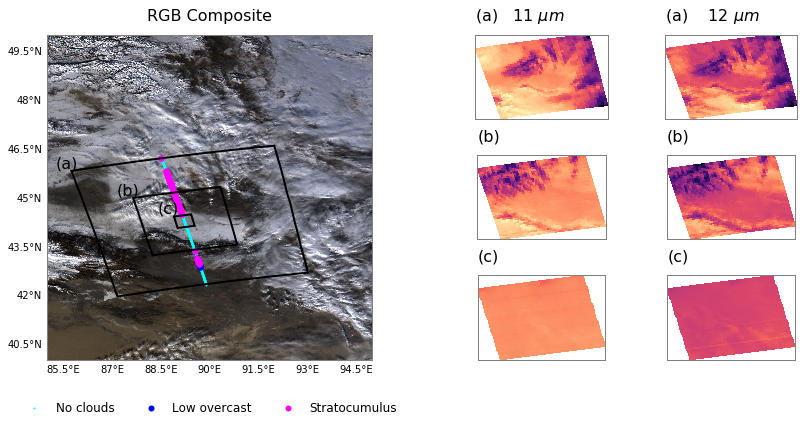

In [98]:
gs = GridSpec(3, 9)
f = plt.figure(figsize = (12, 6))

#
# Modis granule
#
from matplotlib.patches import Polygon
ax, img, _ = plot_modis_granule_composite(modis_granule, modis_geo_granule, grid_spec = gs[:, :5], gain = 0.5)

colors = plt.get_cmap("Greens", 3)
ccs = data.caliop_ss_11_data.variables["cloud_class"][col_ind, :]
inds = ccs == 0
ax.scatter(lons_caliop[inds], lats_caliop[inds], c = "aqua", s = 4.0, label = "No clouds")

ccs = data.caliop_ss_11_data.variables["cloud_class"][col_ind, :]
inds = ccs == 1
ax.scatter(lons_caliop[inds], lats_caliop[inds], c = "blue", label = "Low overcast")

ccs = data.caliop_ss_11_data.variables["cloud_class"][col_ind, :]
inds = ccs == 2
ax.scatter(lons_caliop[inds], lats_caliop[inds], c = "magenta", label = "Stratocumulus")

ax.legend(ncol = 3, loc = "lower center", bbox_to_anchor = [0.5, -0.2], fontsize = 12)

xy = get_boundary(lons_modis_11, lats_modis_11)
p  = Polygon(xy = xy, edgecolor = "black", color = None, fill = False, lw = 2)
ax.add_patch(p)

text_offset = np.array([-0.5, 0.1])
ax.annotate("(a)", xy[xy.shape[0] // 2, :] + text_offset, color = "black", fontsize = 16)

xy = get_boundary(lons_modis_5, lats_modis_5)
p  = Polygon(xy = xy, edgecolor = "black", color = None, fill = False, lw = 2)
ax.add_patch(p)
ax.annotate("(b)", xy[xy.shape[0] // 2, :] + text_offset, color = "black", fontsize = 16)

xy = get_boundary(lons_modis, lats_modis)
p  = Polygon(xy = xy, edgecolor = "black", color = None, fill = False, lw = 2)
ax.add_patch(p)
ax.annotate("(c)", xy[xy.shape[0] // 2, :] + text_offset, color = "black", fontsize = 16)
ax.set_title("RGB Composite", fontsize = 16)


ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)
#
# Input data
#
from cloud_colocations.plots import grid_to_edges

lats = data.modis_ss_11_data.variables["lats"][col_ind, :, :]
lons = data.modis_ss_11_data.variables["lons"][col_ind, :, :]
x = data.modis_ss_11_data.variables["band_30"][col_ind, :, :]
ax, img, gl = plot_scalar_field(x, lats, lons, grid_spec = gs[0, 5:7])
gl.ylabels_left   = False
gl.xlabels_bottom = False
ax.set_title("(a)   11 $\mu m$", loc = "left", size = 16)
norm = img.norm

lats = data.modis_ss_5_data.variables["lats"][col_ind, :, :]
lons = data.modis_ss_5_data.variables["lons"][col_ind, :, :]
x = data.modis_ss_5_data.variables["band_30"][col_ind, :, :]
ax, _, gl = plot_scalar_field(x, lats, lons, grid_spec = gs[1, 5:7], norm = norm)
gl.ylabels_left   = False
gl.xlabels_bottom = False
ax.set_title("(b)", loc = "left", size = 16)

lats = data.modis_data.variables["lats"][col_ind, :, :]
lons = data.modis_data.variables["lons"][col_ind, :, :]
x = data.modis_data.variables["band_30"][col_ind, :, :]
ax, _, gl = plot_scalar_field(x, lats, lons, grid_spec = gs[2, 5:7], norm = norm)
gl.ylabels_left   = False
gl.xlabels_bottom = False
ax.set_title("(c)", loc = "left", size = 16)

lats = data.modis_ss_11_data.variables["lats"][col_ind, :, :]
lons = data.modis_ss_11_data.variables["lons"][col_ind, :, :]
x = data.modis_ss_11_data.variables["band_31"][col_ind, :, :]
ax, img, gl = plot_scalar_field(x, lats, lons, grid_spec = gs[0, 7:])
gl.ylabels_left   = False
gl.xlabels_bottom = False
ax.set_title("(a)    12 $\mu m$", loc = "left", size = 16)
norm = img.norm

lats = data.modis_ss_5_data.variables["lats"][col_ind, :, :]
lons = data.modis_ss_5_data.variables["lons"][col_ind, :, :]
x = data.modis_ss_5_data.variables["band_31"][col_ind, :, :]
ax, _, gl = plot_scalar_field(x, lats, lons, grid_spec = gs[1, 7:], norm = norm)
gl.ylabels_left   = False
gl.xlabels_bottom = False
ax.set_title("(b)", loc = "left", size = 16)

lats = data.modis_data.variables["lats"][col_ind, :, :]
lons = data.modis_data.variables["lons"][col_ind, :, :]
x = data.modis_data.variables["band_31"][col_ind, :, :]
ax, _, gl = plot_scalar_field(x, lats, lons, grid_spec = gs[2, 7:], norm = norm)
gl.ylabels_left   = False
gl.xlabels_bottom = False
ax.set_title("(c)", loc = "left", size = 16)

plt.tight_layout()

f.savefig("../plots/colocation_overview.png", bbox_inches = "tight")

In [97]:
data.caliop_ss_11_data.variables["cloud_class"][col_ind, :]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,

In [142]:
xy


array([[41.9728  , 93.23185 ],
       [42.071568, 93.20964 ],
       [42.171856, 93.18555 ],
       [42.27056 , 93.16297 ],
       [42.37087 , 93.13911 ],
       [42.452976, 93.11093 ],
       [42.55172 , 93.08858 ],
       [42.65201 , 93.064186],
       [42.750587, 93.03999 ],
       [42.850655, 93.01378 ],
       [42.949257, 92.99002 ],
       [43.049366, 92.96396 ],
       [43.1478  , 92.93837 ],
       [43.247704, 92.91039 ],
       [43.34596 , 92.883484],
       [43.427795, 92.85087 ],
       [43.528248, 92.82892 ],
       [43.627205, 92.80898 ],
       [43.727367, 92.78345 ],
       [43.82574 , 92.757675],
       [43.925934, 92.73255 ],
       [44.024624, 92.70965 ],
       [44.12488 , 92.68537 ],
       [44.223534, 92.66239 ],
       [44.323917, 92.63835 ],
       [44.40622 , 92.61156 ],
       [44.504814, 92.587685],
       [44.60513 , 92.56348 ],
       [44.703815, 92.54068 ],
       [44.804108, 92.51587 ],
       [44.90236 , 92.48824 ],
       [45.00137 , 92.45114 ],
       [

In [113]:
col_ind = i
col_ind

2870

In [112]:
data.caliop_ss_11_data.variables["cloud_class"][col_ind, :]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
times = data.meta_data.variables["time"][:]


In [47]:
data.meta_data.variables

OrderedDict([('time', <class 'netCDF4._netCDF4.Variable'>
              float32 time(collocation)
              unlimited dimensions: collocation
              current shape = (1,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lat', <class 'netCDF4._netCDF4.Variable'>
              float32 lat(collocation)
              unlimited dimensions: collocation
              current shape = (1,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lon', <class 'netCDF4._netCDF4.Variable'>
              float32 lon(collocation)
              unlimited dimensions: collocation
              current shape = (1,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('d', <class 'netCDF4._netCDF4.Variable'>
              float32 d(collocation)
              unlimited dimensions: collocation
              current shape = (1,)
              filling on, default _FillValue of 9.96920

In [50]:
times[0]

90102.07

In [31]:
modis_data       = data.modis_data.variables["band_30"]
modis_ss_5_data  = data.modis_ss_5_data.variables["band_30"]
modis_ss_11_data  = data.modis_ss_11_data.variables["band_30"]

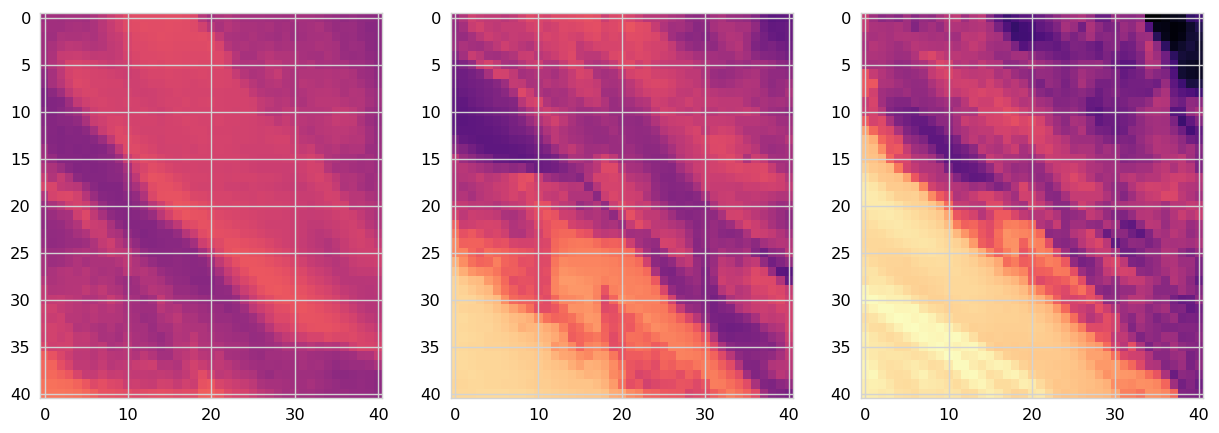

In [43]:
from matplotlib.colors import Normalize
f, axs = plt.subplots(1, 3, figsize = (15, 5))

ind = -1 
norm = Normalize(vmin = modis_ss_11_data[ind, :, :].min(),
                 vmax = modis_ss_11_data[ind, :, :].max())

axs[0].imshow(modis_data[ind, :, :], norm = norm)
axs[1].imshow(modis_ss_5_data[ind, :, :], norm = norm)
axs[2].imshow(modis_ss_11_data[ind, :, :], norm = norm)

In [28]:


times

array([90102.07], dtype=float32)

In [2]:
import os
path = "/home/simonpf/Dendrite/UserAreas/Simon/cloud_collocations/2009/001/"

In [3]:
modis_output = Dataset(os.path.join(path,"modis_20.nc"), "r")
modis_data = np.zeros(modis_output["band_1"].shape + (38,))
for i in range(1, 39):
    modis_data[:, :, :, i - 1] = modis_output["band_" + str(i)][:, :, :]

In [12]:
modis_ss_5_output = Dataset(os.path.join(path,"modis_20_ss_5.nc"), "r")
modis_ss_5_data = np.zeros(modis_ss_5_output["band_1"].shape + (38,))
for i in range(1, 39):
    modis_ss_5_data[:, :, :, i - 1] = modis_ss_5_output["band_" + str(i)][:, :, :]

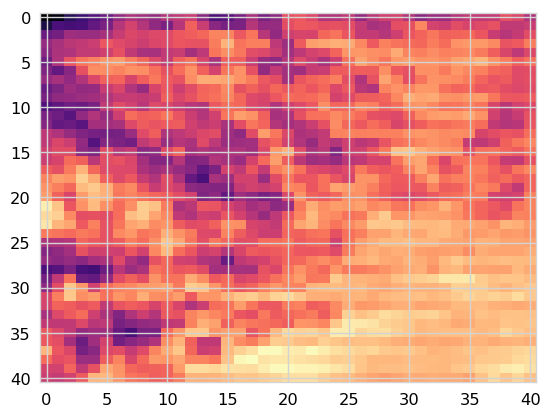

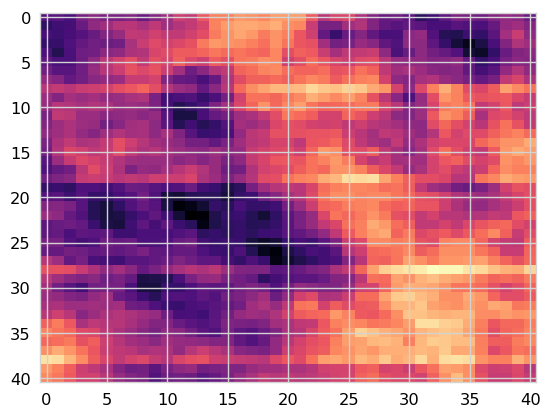

In [13]:
plt.imshow(modis_ss_5_data[0, :, :, 31])
plt.figure()
plt.imshow(modis_data[0, :, :, 31])

In [16]:
caliop_output = Dataset(os.path.join(path, "caliop_20.nc"), "r")

In [24]:
(caliop_output.variables["cloud_class"][0] // 1024) % 8


array([1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2],
      dtype=int32)

In [17]:
from cloud_collocations.plots import plot_composite, plot_swath_cloud_mask
for i in range(4, 10):
    plt.figure()
    img = plot_composite(modis_output, i, bands = [25, 36, 27])
    plot_swath_cloud_mask(caliop_output, i)


UnboundLocalError: local variable 'ax' referenced before assignment

### Cloud types

In [9]:
cloud_classes = caliop_output["cloud_class"][:]

In [11]:
cloud_classes[0, :241189sp
             ]

(344, 101)

(array([14413.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         7957., 12374.]),
 array([1.00000e+00, 2.04510e+03, 4.08920e+03, 6.13330e+03, 8.17740e+03,
        1.02215e+04, 1.22656e+04, 1.43097e+04, 1.63538e+04, 1.83979e+04,
        2.04420e+04]),
 <a list of 10 Patch objects>)

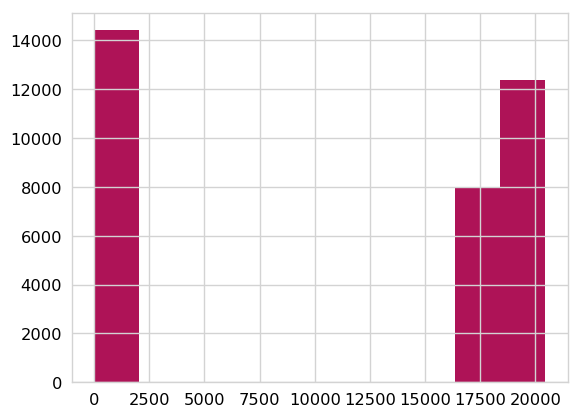

In [10]:
plt.hist(cloud_classes.ravel())

In [110]:
img.get_facecolors()

array([[1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00],
       [1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00],
       [1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00],
       ...,
       [1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00],
       [1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00],
       [1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00]])

In [32]:
modis_data[340, :, :, 26]

array([[0.14554498, 0.14402221, 0.14481179, ..., 0.10426148, 0.10189275,
        0.10268233],
       [0.14610896, 0.14610896, 0.1445298 , ..., 0.1007084 , 0.09991882,
        0.09196667],
       [0.14689852, 0.14847767, 0.14610896, ..., 0.10476907, 0.10713779,
        0.09698611],
       ...,
       [0.12817432, 0.14599615, 0.17464644, ..., 0.08711643, 0.08632685,
        0.08243538],
       [0.12321128, 0.13561888, 0.15891135, ..., 0.08440931, 0.07972826,
        0.07741594],
       [0.12755394, 0.13454732, 0.14622174, ..., 0.0846913 , 0.0815894 ,
        0.08001025]])